In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import funcionalidade as fc
from pylift import TransformedOutcome
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from optbinning import OptimalBinning
from optbinning import BinningProcess
import acessos as ac

(CVXPY) Apr 05 11:54:25 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 05 11:54:25 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
ativos = pd.read_pickle('ativos_fatura_premiada.pkl')
ativos_v1 = ativos.query('grupo_comunicacao != "Sem comunicação"')
ativos_v1['grupo'] = [1 if x == 'Comunicação MCC' else 0 for x in ativos_v1['grupo_comunicacao']]

/tmp/ipykernel_495329/2014758218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ativos_v1['grupo'] = [1 if x == 'Comunicação MCC' else 0 for x in ativos_v1['grupo_comunicacao']]


In [3]:
#conversao
ativos_c = fc.traz_conversao('flavia-costa', '2023-03-17', '2023-03-24', 'cpf', ativos_v1)

In [7]:
ativos_c.columns

Index(['cpf', 'grupo_comunicacao', 'segmento_mcc_agg', 'nr_score_ie',
       'yearmonth_ie', 'status', 'safra', 'grupo', 'conta_cartao', 'converteu',
       'transacoes', 'spending', 'spending_corr', 'transacoes_corr'],
      dtype='object')

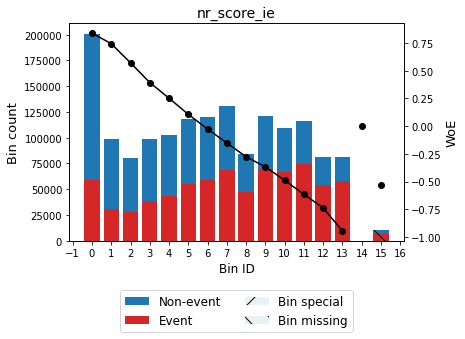

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.29903871
    IV (Jeffrey)             0.28405013
    JS (Jensen-Shannon)      0.03471494
    Hellinger                0.03510425
    Triangular               0.13588867
    KS                       0.22435082
    HHI                      0.07566409
    HHI (normalized)         0.01404170
    Cramer's V               0.26051957
    Quality score            0.90181755

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]  P[B > A]
        0      1   128.267807 9.807507e-30  1.494024e-59       1.0
        1      2   292.519051 1.405031e-65 6.768226e-115       1.0
        2      3   327.290968 3.739601e-73 1.234302e-109       1.0
        3      4   244.069004 5.099310e-55  1.289942e-85       1.0
        4      5   287.730141 1.552904e-64 

In [9]:
#aplicar algoritmo de bin otimizado para dar resultado

variable_names = ['nr_score_ie']


binning_process = BinningProcess(variable_names=variable_names)
binning_process.fit(ativos_c[variable_names], ativos_c['converteu'])

for i in variable_names:
    optb = binning_process.get_binned_variable(name=i)
    optb.binning_table.build()
    optb.binning_table.plot()
    optb.binning_table.analysis()



#http://gnpalencia.org/optbinning/tutorials/tutorial_binary.html

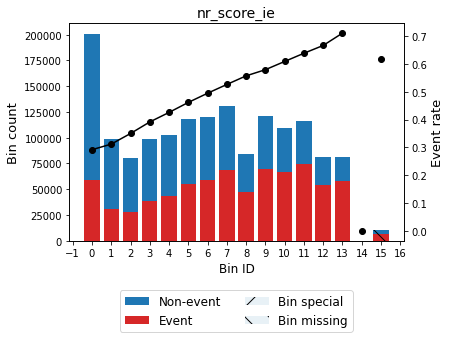

In [16]:
optb.binning_table.plot(metric="event_rate")

In [18]:
#caso queiramos transformar como nova variável
optb = OptimalBinning(name='nr_score_ie', dtype="numerical", solver="cp")
optb.fit(ativos_c['nr_score_ie'].values, ativos_c['converteu'].values)
   

In [20]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 29.29)",201035,0.129250,142410,58625,0.291616,0.839924,0.085368,0.010368
1,"[29.29, 35.25)",98939,0.063610,68096,30843,0.311738,0.744384,0.033421,0.004084
2,"[35.25, 39.18)",80553,0.051789,52370,28183,0.349869,0.57199,0.016388,0.002021
3,"[39.18, 43.39)",98863,0.063561,60169,38694,0.391390,0.393848,0.009689,0.001203
4,"[43.39, 47.35)",102491,0.065894,58868,43623,0.425628,0.252088,0.004153,0.000518
5,"[47.35, 51.52)",118562,0.076226,63836,54726,0.461581,0.106353,0.000860,0.000107
6,"[51.52, 55.49)",119859,0.077060,60577,59282,0.494598,-0.026015,0.000052,0.000007
7,"[55.49, 59.66)",130431,0.083857,61808,68623,0.526125,-0.15222,0.001943,0.000243
8,"[59.66, 62.37)",84637,0.054415,37491,47146,0.557038,-0.276773,0.004156,0.000518
9,"[62.37, 66.44)",120940,0.077755,50893,70047,0.579188,-0.367066,0.010405,0.001293


In [4]:
ativos_c['fx_ie'] = np.where(ativos_c['nr_score_ie'] <= 29.29, 1,
                             np.where(ativos_c['nr_score_ie'] <= 35.25, 2,
                                      np.where(ativos_c['nr_score_ie'] <= 39.18, 3,
                                               np.where(ativos_c['nr_score_ie'] <= 43.39, 4,
                                                        np.where(ativos_c['nr_score_ie'] <= 47.35, 5,
                                                                 np.where(ativos_c['nr_score_ie'] <= 51.52, 6,
                                                                          np.where(ativos_c['nr_score_ie'] <= 55.49, 7,
                                                                                   np.where(ativos_c['nr_score_ie'] <= 59.66, 8,
                                                                                            np.where(ativos_c['nr_score_ie'] <= 62.37, 9,
                                                                                                     np.where(ativos_c['nr_score_ie'] <= 66.44, 10,
                                                                                                              np.where(ativos_c['nr_score_ie'] <= 70.5, 11,
                                                                                                                       np.where(ativos_c['nr_score_ie'] <= 75.71, 12, 13))))))))))))
                                                                                                                                
                                                                                                                                                                                      

In [28]:
ativos_c['fx_ie'].value_counts()

1     201035
13    172905
8     130431
10    120940
7     120266
12    116349
6     116265
11    109837
4     107160
2      98939
5      96084
9      84637
3      80553
Name: fx_ie, dtype: int64

In [30]:
import funcionalidade as fc

ativos_c['grupo'] = ['alvo' if x == 'Comunicação MCC' else 'controle' for x in ativos_c['grupo_comunicacao']]


for x in range(1,13):
    temp_df = pd.DataFrame()
    print(f"=============Faixa de IE: {x}============")
    temp_df = ativos_c[ativos_c['fx_ie'] == x]
    fc.testes_iterativos(temp_df)

=============Faixa de IE: 1============
           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      182572  0.291501  386.000760  20542960.45   3.320763  176731.0
controle   18463  0.292748  383.041049   2070336.87   3.237558   17499.0
_____________________
Lift da conversão: -0.43%
Estatística t do teste de diferença de proporções: -0.36
P-valor do teste de diferença de proporções: 0.722555
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 0.77%
Estatística t do teste de spending: 0.11
P-valor do teste de spending: 0.916123
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.57%
Estatística t do teste de frequencia: 0.96
P-valor do teste de freque

In [23]:
optb = OptimalBinning(name='segmento_mcc_agg', dtype="categorical", solver="cp")
optb.fit(ativos_c['segmento_mcc_agg'].values, ativos_c['converteu'].values)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0 - OUTROS],696962,0.448092,424105,272857,0.391495,0.393408,0.068155,0.008465
1,[1 - SUPERMERCADO],112159,0.072109,56302,55857,0.498016,-0.03969,0.000114,0.000014
2,[2 - LOJAS DE DEPARTAMENTO],195689,0.125813,97287,98402,0.502849,-0.059021,0.000438,0.000055
3,[3 - SERVICOS DE ALIMENTACAO],200283,0.128766,82867,117416,0.586250,-0.396111,0.020037,0.002488
4,[5 - LOJAS ESPECIALIZADAS],111674,0.071798,44699,66975,0.599737,-0.451993,0.014500,0.001797
5,[4 - SAUDE],238634,0.153423,90956,147678,0.618847,-0.532283,0.042735,0.005280
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1555401,1.000000,796216,759185,0.488096,,0.145980,0.018099


In [5]:
personas = ac.df_athena_q('flavia-costa', 
                          """select 
                                cpf
                                , max(ds_cluster_sociodemographic) as ds_cluster_sociodemographic
                                from customer_curated_zone.ca_book_cliente_cluster cl
                                left join customer_curated_zone.ca_book_cliente ci on (ci.id_customer = cl.id_customer)
                                group by 1 """)

ativos_p = ativos_c.join(personas.set_index('cpf'), how = 'left', on = 'cpf')

In [6]:
limite_disp = ac.df_athena_q('flavia-costa', 
                          """with base_limite_diaria as (
                                    select
                                    dt_data
                                    , cpf
                                    , limite
                                    , (limite - utilizado) as limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_will
                                    where dt_data < to_date('2023-03-17','yyyy-mm-dd')
                                    union all
                                    select
                                    dt_movimentacao as dt_data 
                                    , cpf 
                                    , limite
                                    , limite_disponivel
                                    , iu
                                    from credit_curated_zone.credit_iu_pag
                                    where dt_movimentacao < to_date('2023-03-17','yyyy-mm-dd')
                                    )
                                    , base_lim_rankeada as (
                                    select *
                                    , row_number() over (partition by cpf order by cpf asc, dt_data desc, iu desc) as linha
                                    from base_limite_diaria
                                    )
                                    select 
                                    cpf
                                    , max(limite) as limite
                                    , min(limite_disponivel) as limite_disponivel
                                    , max(iu) as iu
                                    from base_lim_rankeada
                                    where linha = 1
                                    group by 1 """)

ativos_p = ativos_p.join(limite_disp.set_index('cpf'), how = 'left', on = 'cpf')

In [7]:
ativos_p['grupo'] = [1 if x == 'Comunicação MCC' else 0 for x in ativos_p['grupo_comunicacao']]

In [33]:
optb = OptimalBinning(name='ds_cluster_sociodemographic', dtype="categorical", solver="cp")
optb.fit(ativos_p['ds_cluster_sociodemographic'].values, ativos_p['converteu'].values)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[12 - Mulher, Solteira, 35 anos ou mais, cidad...",94935,0.061036,52207,42728,0.450076,0.152737,0.001419,1.771458e-04
1,"[9 - Homem, Solteiro, Entre 25 e 34 anos, cida...",117439,0.075504,63713,53726,0.457480,0.122867,0.001137,1.420020e-04
2,"[16 - Homem, 25 a 40 anos, Nordeste, 23 - Home...",223737,0.143845,118315,105422,0.471187,0.067754,0.000660,8.242875e-05
3,"[30 - Homem, Até 24 anos, Centro-Oeste e Norte...",151038,0.097106,78684,72354,0.479045,0.036244,0.000127,1.593563e-05
4,"[19 - Mulher, 41 anos ou mais, Nordeste, 17 - ...",158965,0.102202,81521,77444,0.487176,0.003681,0.000001,1.730508e-07
5,"[15 - Mulher, 25 a 40 anos, Nordeste]",187852,0.120774,95742,92110,0.490333,-0.008951,0.000010,1.209798e-06
6,"[10 - Mulher, Solteira, Até 24 anos, cidade Pe...",134381,0.086396,68028,66353,0.493768,-0.022695,0.000045,5.563399e-06
7,"[28 - Mulher, Até 24 anos, Centro-Oeste e Nort...",169304,0.108849,84497,84807,0.500916,-0.051287,0.000286,3.579918e-05
8,"[22 - Mulher, 41 anos ou mais, Sudeste e Sul, ...",209781,0.134873,101592,108189,0.515724,-0.11054,0.001649,2.059588e-04
9,"[8 - Mulher, Solteira, Até 24 anos, cidade Peq...",90862,0.058417,43018,47844,0.526557,-0.153952,0.001384,1.728745e-04


In [34]:
print(binning_table.build())

                                                      Bin    Count  Count (%)  \
0       [12 - Mulher, Solteira, 35 anos ou mais, cidad...    94935   0.061036   
1       [9 - Homem, Solteiro, Entre 25 e 34 anos, cida...   117439   0.075504   
2       [16 - Homem, 25 a 40 anos, Nordeste, 23 - Home...   223737   0.143845   
3       [30 - Homem, Até 24 anos, Centro-Oeste e Norte...   151038   0.097106   
4       [19 - Mulher, 41 anos ou mais, Nordeste, 17 - ...   158965   0.102202   
5                   [15 - Mulher, 25 a 40 anos, Nordeste]   187852   0.120774   
6       [10 - Mulher, Solteira, Até 24 anos, cidade Pe...   134381   0.086396   
7       [28 - Mulher, Até 24 anos, Centro-Oeste e Nort...   169304   0.108849   
8       [22 - Mulher, 41 anos ou mais, Sudeste e Sul, ...   209781   0.134873   
9       [8 - Mulher, Solteira, Até 24 anos, cidade Peq...    90862   0.058417   
10                                                Special        0   0.000000   
11                          

In [8]:
optb = OptimalBinning(name='limite_disponivel', dtype="categorical", solver="cp")
optb.fit(ativos_p['limite_disponivel'].values, ativos_p['converteu'].values)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-77328.57, 1981.57, 1981.48, 1981.47, 1981.46...",297047,0.190978,289299,7748,0.026083,3.571565,1.260705,0.106003
1,"[4.9500000000000455, 1.6700000000000017, -1.53...",112966,0.072628,83569,29397,0.260229,0.996319,0.065933,0.007917
2,"[0.2600000000000051, 3.0999999999999943, 0.970...",116157,0.074680,77963,38194,0.328814,0.665095,0.031623,0.003882
3,"[2560.0, 1833.5, 664.17, 2052.95, 40.699999999...",77782,0.050008,49602,28180,0.362295,0.516957,0.012995,0.001607
4,"[220.0, 350.0, 4.230000000000018, 0.1599999999...",116081,0.074631,67194,48887,0.421146,0.269611,0.005375,0.000670
5,"[37.0, 585.0, 1.0300000000000011, 156.0, 2.75,...",77774,0.050003,39138,38636,0.496773,-0.035552,0.000063,0.000008
6,"[2400.98, 6066.13, 681.72, 2400.95, 53.0800000...",87914,0.056522,43957,43957,0.500000,-0.048461,0.000133,0.000017
7,"[1091.24, 1264.09, 1091.34, 1091.08, 521.62, 5...",77772,0.050001,37573,40199,0.516883,-0.116018,0.000673,0.000084
8,"[421.0, 237.0, 358.0, 125.5, 53.5, 7.279999999...",88632,0.056983,35837,52795,0.595665,-0.435897,0.010715,0.001329
9,"[40.5, 9.069999999999993, 13.310000000000002, ...",106078,0.068200,35528,70550,0.665077,-0.734462,0.035523,0.004343


In [9]:
for column in ativos_p.columns:
  if ativos_p[column].dtype == 'object':
    ativos_p[column].fillna(ativos_p[column].mode()[0], inplace = True)
  elif ativos_p[column].dtype != 'object':
    ativos_p[column].fillna(ativos_p[column].median(), inplace = True)

In [10]:
ativos_p['ds_cluster_sociodemographic'] = np.where(ativos_p['ds_cluster_sociodemographic'] == None, ativos_p['ds_cluster_sociodemographic'].mode()[0], ativos_p['ds_cluster_sociodemographic'])
ativos_p['ds_cluster_sociodemographic'] = ativos_p['ds_cluster_sociodemographic'].astype('string')

In [11]:
ativos_p['cluster_persona'] = ativos_p['ds_cluster_sociodemographic'].str[0:2]
ativos_p['cluster_persona'] = ativos_p['cluster_persona'].astype('int')

In [12]:
ativos_p = ativos_p.replace([np.inf, -np.inf], 0)

In [16]:
clf = LogisticRegression()
up = TransformedOutcome(ativos_p.query('nr_score_ie >= 0').query('segmento_mcc_agg != "0 - OUTROS"')[['grupo', 'converteu', 'limite_disponivel', 'limite', 'iu',
                                                            'nr_score_ie','segmento_mcc_agg','cluster_persona']]
                        , col_treatment='grupo', col_outcome='converteu', sklearn_model=LogisticRegression)

<AxesSubplot:xlabel='NIV', ylabel='Features'>

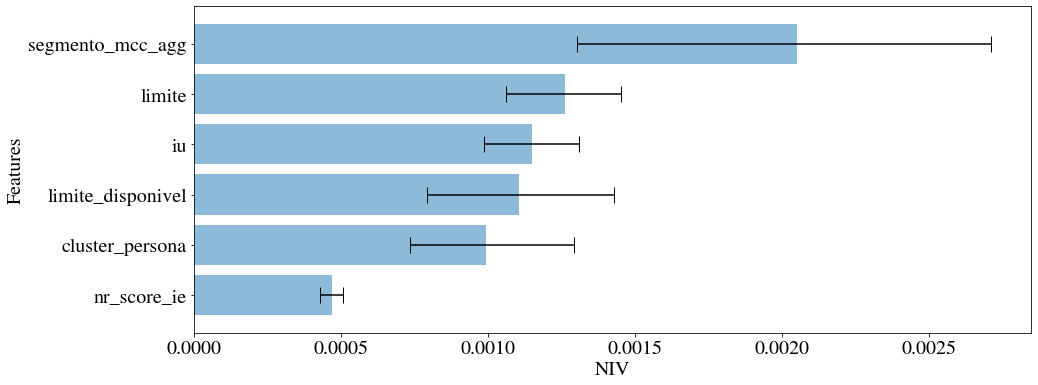

In [17]:
up.NIV()

<AxesSubplot:title={'center':'NWOE by bin for cluster_persona'}, xlabel='Bin Interval'>

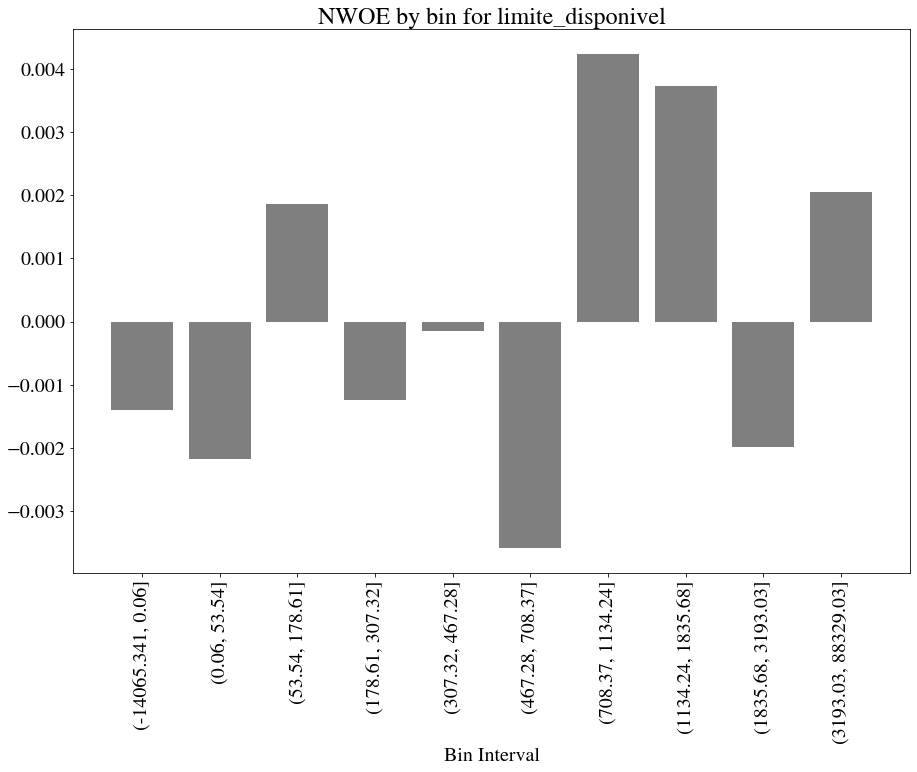

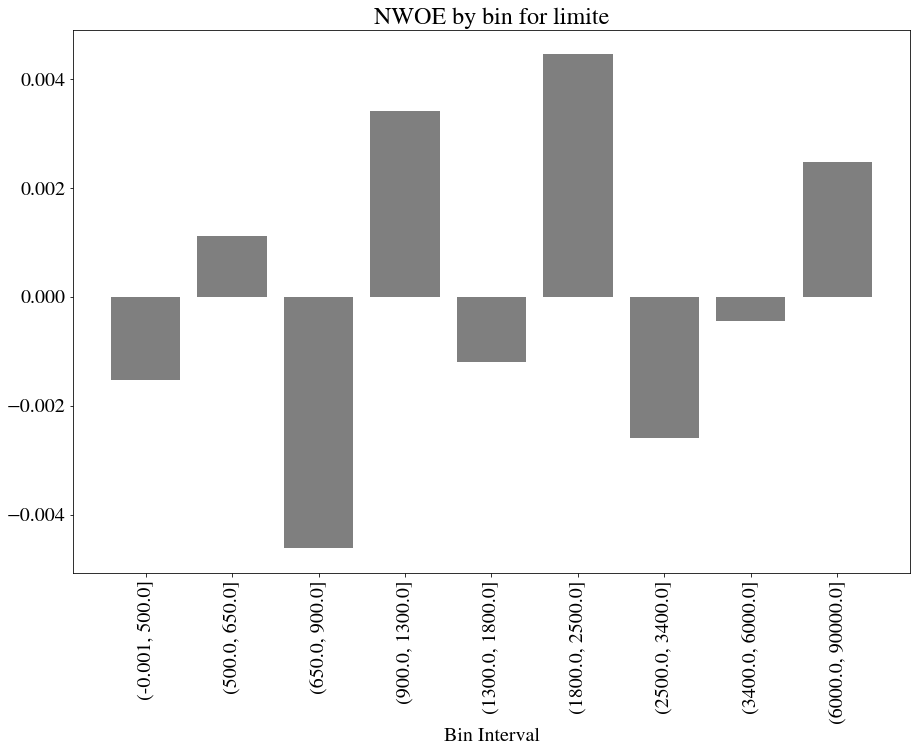

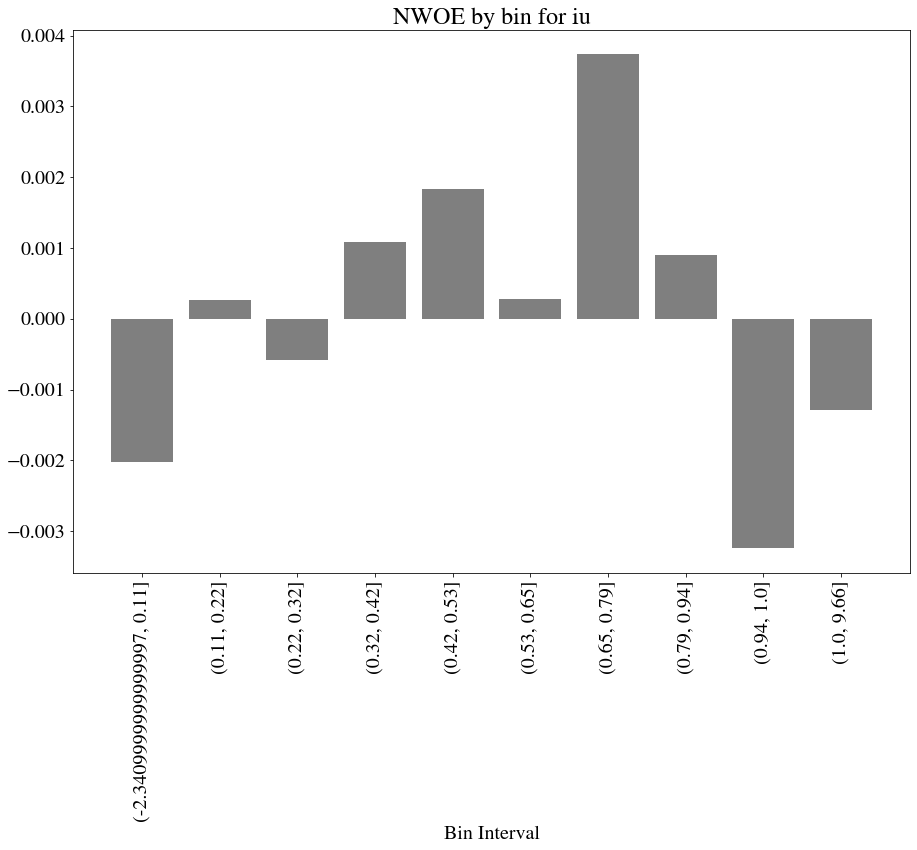

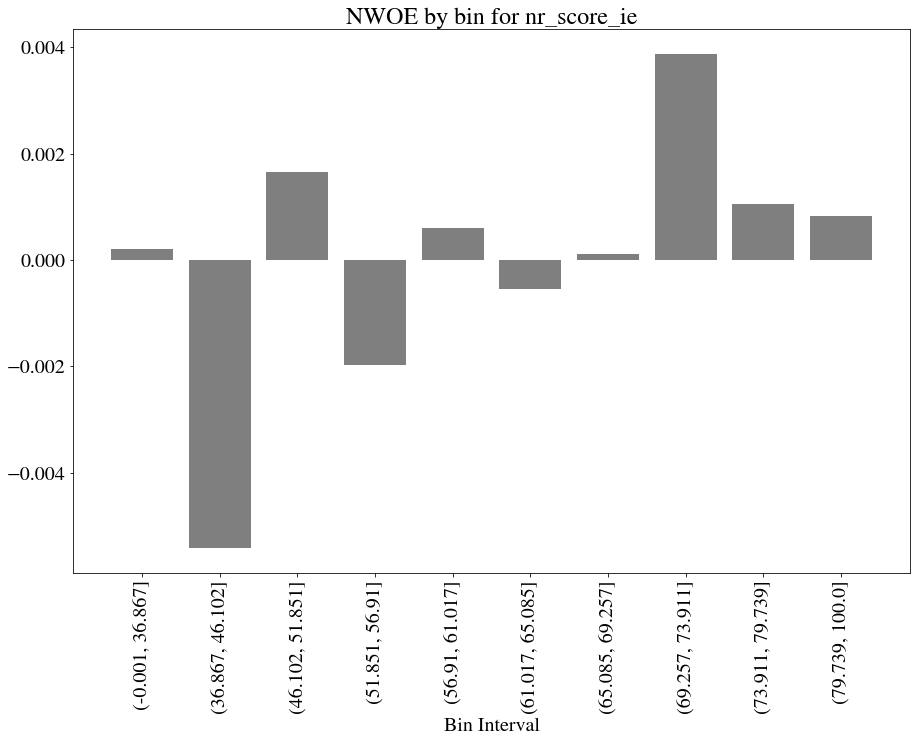

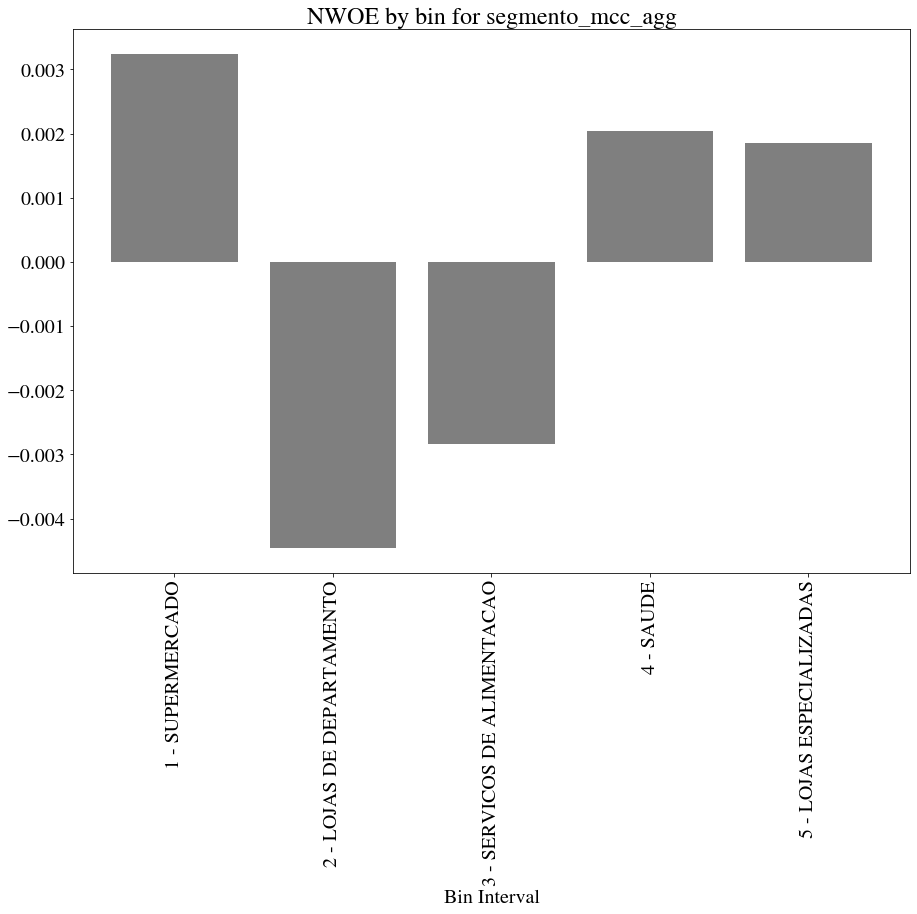

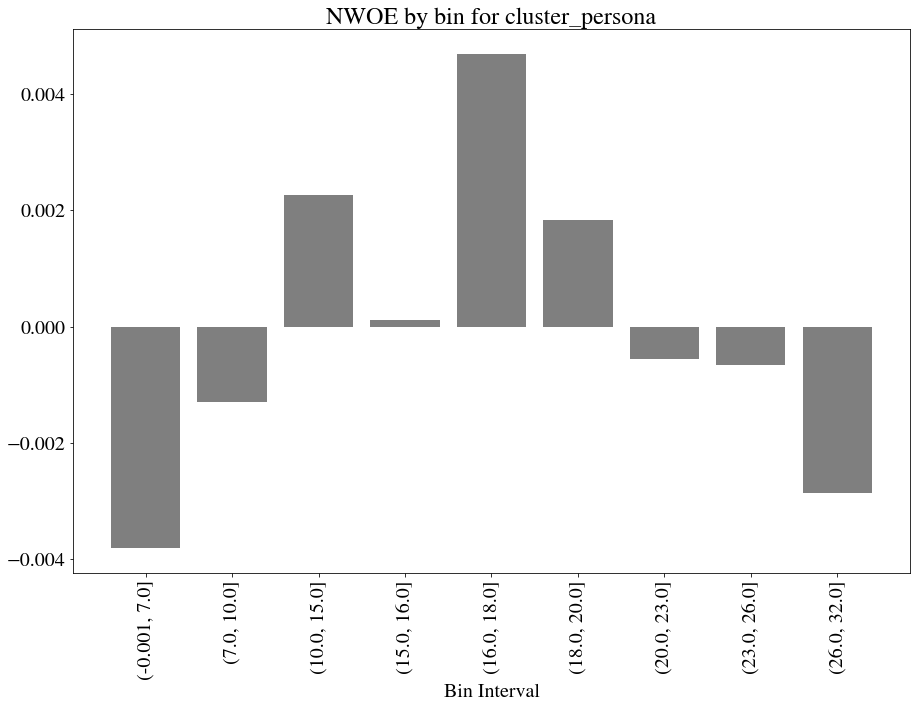

In [18]:
up.NWOE()

In [19]:
import funcionalidade as fc

ativos_p['grupo'] = ['alvo' if x == 'Comunicação MCC' else 'controle' for x in ativos_c['grupo_comunicacao']]

fc.testes_iterativos(ativos_p.query('segmento_mcc_agg != "0 - OUTROS"').query('limite_disponivel >= 710').query('limite_disponivel < 2000'))

           grupo converteu    spending              transacoes          
           count      mean        mean          sum       mean       sum
grupo                                                                   
alvo      166957  0.619207  295.715442  49371763.03   3.219206  537469.0
controle   18734  0.612256  299.715915   5614877.96   3.150475   59021.0
_____________________
Lift da conversão: 1.14%
Estatística t do teste de diferença de proporções: 1.86
P-valor do teste de diferença de proporções: 0.063265
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -1.33%
Estatística t do teste de spending: -0.95
P-valor do teste de spending: 0.340955
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 2.18%
Estatística t do teste de frequencia: 3.01
P-valor do teste de frequencia: 0.002581
A diferença de frequência

In [20]:
fc.testes_iterativos(ativos_p.query('segmento_mcc_agg != "0 - OUTROS"').query('nr_score_ie >= 69.25').query('nr_score_ie < 74'))

          grupo converteu    spending              transacoes          
          count      mean        mean          sum       mean       sum
grupo                                                                  
alvo      79233  0.647205  284.143525  22513543.91   3.374920  267405.0
controle   8753  0.638981  277.870118   2432197.14   3.337256   29211.0
_____________________
Lift da conversão: 1.29%
Estatística t do teste de diferença de proporções: 1.53
P-valor do teste de diferença de proporções: 0.126706
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: 2.26%
Estatística t do teste de spending: 1.45
P-valor do teste de spending: 0.145979
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 1.13%
Estatística t do teste de frequencia: 1.35
P-valor do teste de frequencia: 0.177111
A diferença de frequência não é 

In [21]:
fc.testes_iterativos(ativos_p.query('segmento_mcc_agg != "0 - OUTROS"').query('iu >= 0.65').query('iu <= 0.79'))

          grupo converteu    spending              transacoes          
          count      mean        mean          sum       mean       sum
grupo                                                                  
alvo      87565  0.638429  271.914204  23810167.24   3.287958  287910.0
controle   9769  0.635377  279.840918   2733765.93   3.282629   32068.0
_____________________
Lift da conversão: 0.48%
Estatística t do teste de diferença de proporções: 0.6
P-valor do teste de diferença de proporções: 0.551661
Conclusão:
A diferença de conversão não é significativa
______________________________________________________________
Lift do spending: -2.83%
Estatística t do teste de spending: -1.56
P-valor do teste de spending: 0.117827
Conclusão:
A diferença de spending não é significativa
______________________________________________________________
Lift da frequência: 0.16%
Estatística t do teste de frequencia: 0.31
P-valor do teste de frequencia: 0.760192
A diferença de frequência não é

In [94]:
ativos_p['fx_ie'] = np.where(ativos_p['nr_score_ie'] <= 29.29, 1,
                             np.where(ativos_p['nr_score_ie'] <= 35.25, 2,
                                      np.where(ativos_p['nr_score_ie'] <= 39.18, 3,
                                               np.where(ativos_p['nr_score_ie'] <= 43.39, 4,
                                                        np.where(ativos_p['nr_score_ie'] <= 47.35, 5,
                                                                 np.where(ativos_p['nr_score_ie'] <= 51.52, 6,
                                                                          np.where(ativos_p['nr_score_ie'] <= 55.49, 7,
                                                                                   np.where(ativos_p['nr_score_ie'] <= 59.66, 8,
                                                                                            np.where(ativos_p['nr_score_ie'] <= 62.37, 9,
                                                                                                     np.where(ativos_p['nr_score_ie'] <= 66.44, 10,
                                                                                                              np.where(ativos_p['nr_score_ie'] <= 70.5, 11,
                                                                                                                       np.where(ativos_p['nr_score_ie'] <= 75.71, 12, 13))))))))))))

In [104]:
ativos_p.query('nr_score_ie >= 0')

ativos_p['combinacao'] = ativos_p['fx_ie'].astype("string") + "|" + ativos_p['cluster_persona'].astype("string") + "|" + ativos_p['segmento_mcc_agg'].astype("string")

ativos_p['combinacao']

0          2|26|1 - SUPERMERCADO
1          6|10|1 - SUPERMERCADO
2          8|23|1 - SUPERMERCADO
3          8|10|1 - SUPERMERCADO
4         11|15|1 - SUPERMERCADO
                   ...          
774852           5|17|0 - OUTROS
774854           10|7|0 - OUTROS
774855            1|2|0 - OUTROS
774856           7|17|0 - OUTROS
774857           7|16|0 - OUTROS
Name: combinacao, Length: 1555401, dtype: string

In [107]:
ativos_p['combinacao'].fillna(ativos_p['combinacao'].mode()[0], inplace = True)

In [117]:
ativos_p['combinacao'] = ativos_p['combinacao'].replace(to_replace = np.nan, value = "NI")

In [115]:
ativos_p[ativos_p['combinacao'].isnull() == True]

,cpf,grupo_comunicacao,segmento_mcc_agg,nr_score_ie,yearmonth_ie,status,safra,grupo,conta_cartao,converteu,transacoes,spending,spending_corr,transacoes_corr,ds_cluster_sociodemographic,TransformedOutcome,cluster_persona,fx_ie,combinacao


In [114]:
ativos_p[ativos_p['combinacao'] == None]

,cpf,grupo_comunicacao,segmento_mcc_agg,nr_score_ie,yearmonth_ie,status,safra,grupo,conta_cartao,converteu,transacoes,spending,spending_corr,transacoes_corr,ds_cluster_sociodemographic,TransformedOutcome,cluster_persona,fx_ie,combinacao


In [120]:
ativos_p = ativos_p.dropna(how = 'all')

In [123]:
len(ativos_p)

1555401

In [128]:
ativos_p.combinacao = ativos_p.combinacao.astype("string")

In [131]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
label_encoder = LabelEncoder()

# fit the encoder to the categorical variable
label_encoder.fit(ativos_p.combinacao)

# transform the categorical variable into numerical values
ativos_p['comb'] = label_encoder.transform(ativos_p.combinacao)

In [132]:
up = TransformedOutcome(ativos_p.query('nr_score_ie >= 0')[['grupo', 'converteu', 'comb']], col_treatment='grupo', col_outcome='converteu', sklearn_model=LogisticRegression)

<AxesSubplot:title={'center':'NWOE by bin for comb'}, xlabel='Bin Interval'>

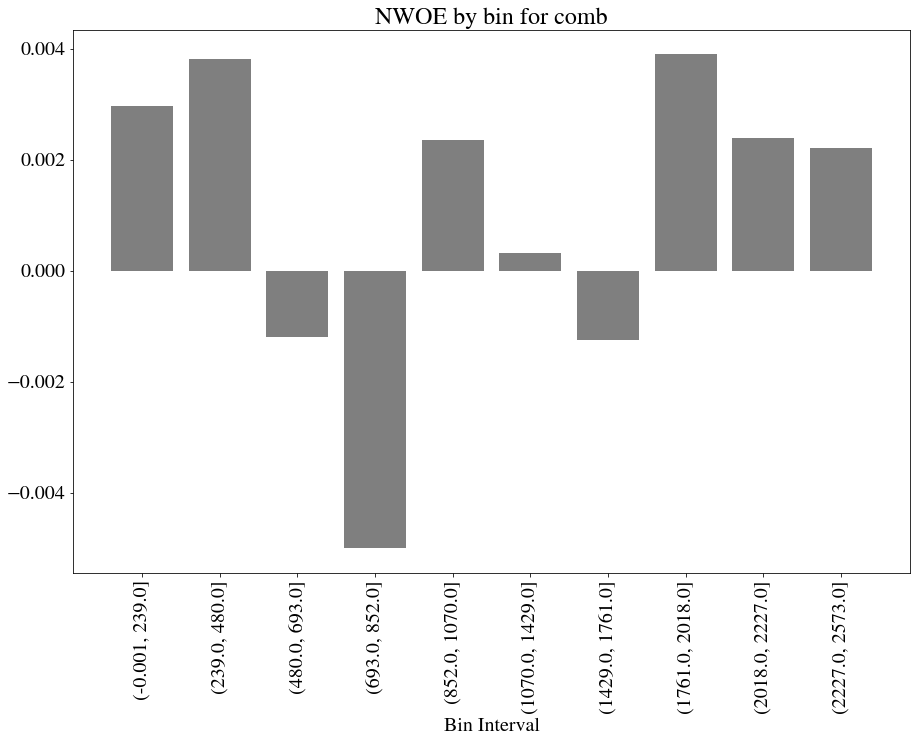

In [133]:
up.NWOE()

In [ ]:
#separar teste e controle e rodar abaixo

In [134]:
optb = OptimalBinning(name='combinacao', dtype="categorical", solver="cp")
optb.fit(ativos_p['combinacao'].values, ativos_p['converteu'].values)
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2|4|5 - LOJAS ESPECIALIZADAS, 2|9|3 - SERVICO...",89091,0.057278,68510,20581,0.231011,1.154986,0.068069,8.065178e-03
1,"[1|15|0 - OUTROS, 1|19|0 - OUTROS, 2|9|0 - OUT...",78345,0.050370,58330,20015,0.255473,1.02201,0.047927,5.743088e-03
2,"[1|5|0 - OUTROS, 2|26|5 - LOJAS ESPECIALIZADAS...",130277,0.083758,89240,41037,0.314998,0.72923,0.042314,5.175133e-03
3,"[1|19|1 - SUPERMERCADO, 4|16|0 - OUTROS, 1|5|1...",98162,0.063110,62326,35836,0.365070,0.505801,0.015718,1.944009e-03
4,"[1|10|1 - SUPERMERCADO, 2|15|5 - LOJAS ESPECIA...",84151,0.054102,50669,33482,0.397880,0.366681,0.007163,8.903933e-04
5,"[4|14|2 - LOJAS DE DEPARTAMENTO, 5|10|1 - SUPE...",97927,0.062959,55909,42018,0.429075,0.238002,0.003540,4.414105e-04
6,"[1|23|3 - SERVICOS DE ALIMENTACAO, 3|14|4 - SA...",101168,0.065043,54518,46650,0.461114,0.108233,0.000760,9.498080e-05
7,"[7|30|3 - SERVICOS DE ALIMENTACAO, 6|22|2 - LO...",124971,0.080346,63770,61201,0.489722,-0.006506,0.000003,4.251031e-07
8,"[5|18|5 - LOJAS ESPECIALIZADAS, 6|30|1 - SUPER...",144075,0.092629,69000,75075,0.521083,-0.132006,0.001614,2.016421e-04
9,"[7|21|4 - SAUDE, 9|7|2 - LOJAS DE DEPARTAMENTO...",136759,0.087925,60978,75781,0.554121,-0.264959,0.006156,7.672701e-04


In [135]:
binning_table.build().to_csv('test.csv')

: 